In [1]:
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time
import os
import matplotlib

In [2]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
class SphereFilter(hoomd.filter.CustomFilter):
    def __init__(self, radius):
        self.radius = radius

    def __hash__(self):
        return hash((self.radius))

    def __eq__(self, other):
        return (isinstance(other, SphereFilter)
                and self.radius == other.radius)

    def __call__(self, state):
        with state.cpu_local_snapshot as snap:
            positions = snap.particles.position
            indices = (np.sum(positions*positions, axis=1) < (self.radius*self.radius))
            return np.copy(snap.particles.tag[indices])

In [4]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='npt_target.gsd')


In [5]:
integrator = hoomd.md.Integrator(dt=1e-2) # was 1e-3 changed because higher temp means atoms have important interactions fast
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell) 
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0
integrator.forces.append(lj)

In [6]:
#thisfilter = SphereFilter(3.5) # change this num 3, 6

In [7]:
#nvt --> nve
nve = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All())
integrator.methods.clear()  # Remove all existing methods
integrator.methods.append(nve)
simulation.operations.integrator = integrator

In [8]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
thermodynamic_propertiesII = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

simulation.operations.computes.append(thermodynamic_propertiesII)
simulation.operations.computes.append(thermodynamic_properties)
simulation.always_compute_pressure = False
simulation.run(1)

In [9]:
scale_factor = 5.5

In [10]:
initial_temperature = thermodynamic_properties.kinetic_temperature

In [11]:
#simulation.state.thermalize_particle_momenta(filter=thisfilter, kT=100) #change temp of filter particle 100, 14

In [12]:
#simulation.run(500) # 10000 number of repitions with hot spot (note: will not work correctly with NVT state)

In [13]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists("spike_case_one.h5"):
    os.remove("spike_case_one.h5") # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(10),
                                  filename='spike_case_one.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [14]:
loggerII = hoomd.logging.Logger(categories=['scalar', 'sequence'])
loggerII.add(thermodynamic_propertiesII)
loggerII.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists("heatedParticles_case_one.h5"):
    os.remove("heatedParticles_case_one.h5") # clear file if already created
    
hdf5_writerII = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(10),
                                  filename='heatedParticles_case_one.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writerII)

In [15]:
simulation.run(4000) # 10000

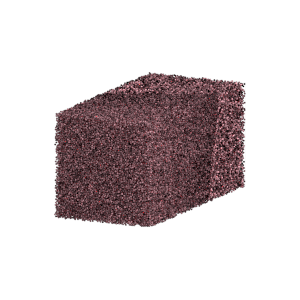

In [16]:
render(simulation.state.get_snapshot())

In [17]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.005163124017574877

In [18]:
simulation.operations.writers.remove(hdf5_writer)
hdf5_file = h5py.File(name='spike_case_one.h5', mode='r') # change name to normalized , case_one_spike etc.

In [19]:
pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [20]:
# heated particles logged
simulation.operations.writers.remove(hdf5_writerII)
hdf5_file_heated = h5py.File(name='heatedParticles_case_one.h5', mode='r') # change name to normalized_heatedParticles , case_one_heatedParticles etc.

In [21]:
pressure_data_only_heated = np.float64(hdf5_file_heated['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:])
temperature_data_only_heated = np.float64(hdf5_file_heated['hoomd-data/md/compute/ThermodynamicQuantities/kinetic_temperature'][:])

In [22]:
current_temperature_spike = thermodynamic_properties.kinetic_temperature
print(current_temperature_spike)

1.1028124082215658


In [23]:
print("Pressure Data:", temperature_data)

Pressure Data: [1.10281052 1.10280939 1.10280829 1.10280721 1.10280616 1.10280514
 1.10280414 1.10280317 1.10280223 1.10280131 1.10280041 1.10279955
 1.1027987  1.10279789 1.1027971  1.10279633 1.10279559 1.10279487
 1.10279418 1.10279351 1.10279287 1.10279225 1.10279166 1.10279109
 1.10279055 1.10279003 1.10278953 1.10278906 1.10278861 1.10278819
 1.10278779 1.10278741 1.10278706 1.10278673 1.10278642 1.10278614
 1.10278587 1.10278564 1.10278542 1.10278523 1.10278506 1.10278491
 1.10278478 1.10278468 1.1027846  1.10278454 1.1027845  1.10278449
 1.10278449 1.10278452 1.10278457 1.10278464 1.10278473 1.10278485
 1.10278498 1.10278514 1.10278532 1.10278552 1.10278573 1.10278597
 1.10278624 1.10278652 1.10278682 1.10278714 1.10278748 1.10278785
 1.10278823 1.10278863 1.10278906 1.1027895  1.10278997 1.10279045
 1.10279095 1.10279148 1.10279202 1.10279258 1.10279317 1.10279377
 1.10279439 1.10279503 1.10279569 1.10279637 1.10279707 1.10279779
 1.10279853 1.10279929 1.10280006 1.10280086 1.

In [24]:
#pressure_data = np.float64(hdf5_file['hoomd-data/md/compute/ThermodynamicQuantities/pressure'][:]) # pull data from log file

In [25]:
current_pressure_spike = thermodynamic_properties.pressure
print(current_pressure_spike)

0.005163124017574877


In [26]:
print("Pressure Data:", pressure_data)

Pressure Data: [0.00464764 0.00465757 0.00466737 0.00467685 0.00468633 0.00469581
 0.00470499 0.0047142  0.00472327 0.00473229 0.00474112 0.00474977
 0.0047584  0.00476698 0.00477539 0.00478377 0.00479202 0.00480036
 0.00480847 0.00481637 0.00482419 0.004832   0.0048397  0.00484732
 0.00485477 0.0048622  0.00486962 0.00487682 0.00488393 0.00489095
 0.00489792 0.00490472 0.00491142 0.0049181  0.00492478 0.00493119
 0.00493741 0.00494368 0.00494972 0.00495574 0.00496177 0.00496768
 0.00497341 0.00497905 0.00498476 0.00499019 0.00499566 0.00500101
 0.00500629 0.00501137 0.00501642 0.00502147 0.0050263  0.00503095
 0.0050356  0.00504011 0.00504474 0.00504915 0.00505353 0.00505779
 0.00506205 0.00506619 0.00507013 0.00507408 0.00507785 0.00508154
 0.0050853  0.0050891  0.00509263 0.00509602 0.00509941 0.00510261
 0.00510589 0.00510902 0.00511201 0.00511491 0.00511779 0.00512051
 0.00512345 0.0051261  0.00512852 0.00513101 0.00513352 0.00513587
 0.00513801 0.00514012 0.00514217 0.00514414 0.

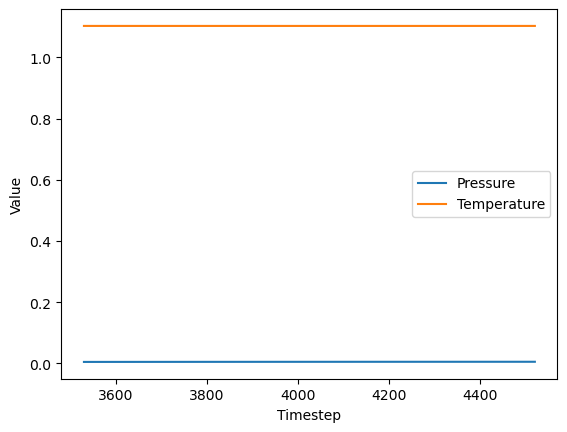

In [27]:
# pressure vs time
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data, label='Pressure')
plt.plot(timesteps, temperature_data, label='Temperature')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

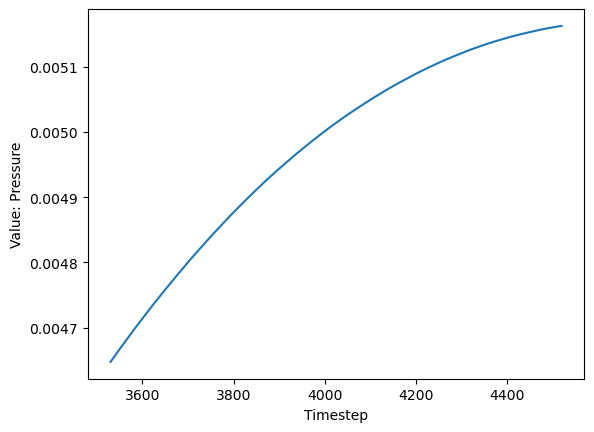

In [28]:
plt.plot(timesteps, pressure_data)
plt.xlabel('Timestep')
plt.ylabel('Value: Pressure')
plt.show()

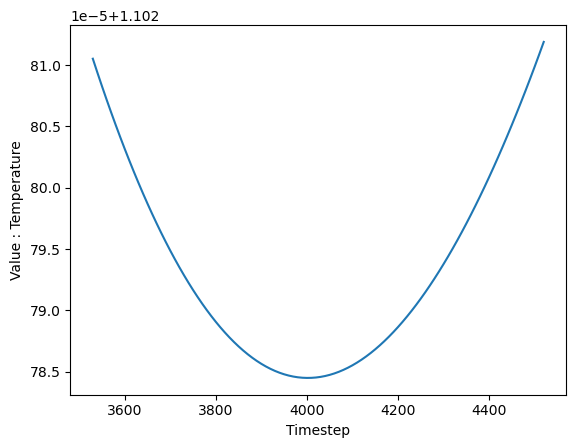

In [29]:
plt.plot(timesteps, temperature_data)
plt.xlabel('Timestep')
plt.ylabel('Value : Temperature')
plt.show()

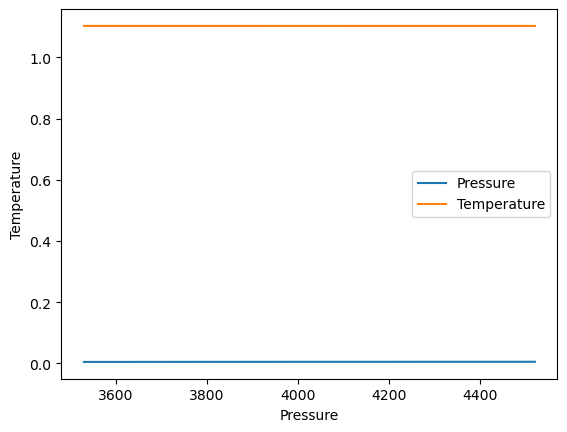

In [30]:
# pressure vs time ; only heated particles
timesteps = np.float64(hdf5_file['hoomd-data/Simulation/timestep'][:])

plt.plot(timesteps, pressure_data_only_heated , label='Pressure')
plt.plot(timesteps, temperature_data_only_heated, label='Temperature')
plt.xlabel('Pressure')
plt.ylabel('Temperature')
plt.legend()
plt.show()

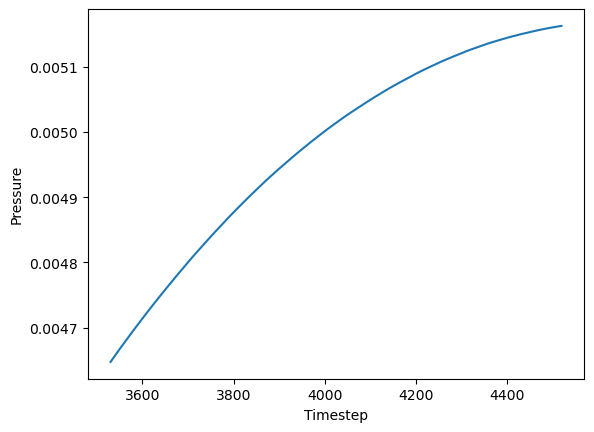

In [31]:
plt.plot(timesteps, pressure_data_only_heated)
plt.xlabel('Timestep')
plt.ylabel('Pressure')
plt.show()

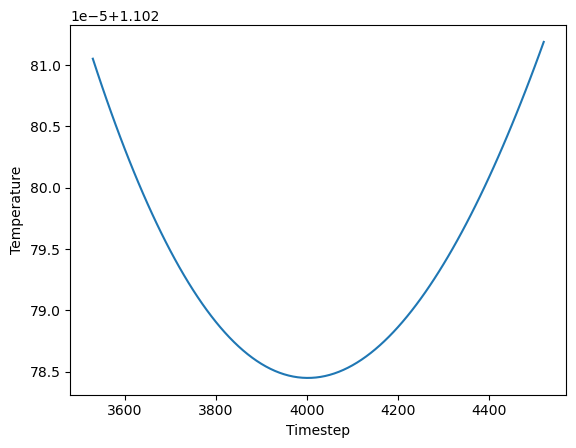

In [32]:
plt.plot(timesteps, temperature_data_only_heated)
plt.xlabel('Timestep')
plt.ylabel('Temperature')
plt.show()